In [2]:
from typing import Any, Callable, List, Optional, Tuple, Dict
import json, sys
import numpy as np
import pandas as pd
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from utils.env_utils import keep_only_core_observations, keep_only_electrical_storage

print('Python:', sys.version.split()[0])
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-27 16:12:29.759389: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 16:12:29.774277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756303949.789498  300754 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756303949.793833  300754 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756303949.806389  300754 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
CityLearn: 2.4.1


In [3]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
NAME_TO_FRAC = {
    '100%_discharge': -1.0,
    '50%_discharge': -0.5,
    'idle': 0.0,
    '50%_charge': 0.5,
    '100%_charge': 1.0,
}

In [4]:
class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str], # ['soc', 'price', 'net_load', 'solar_generation']
                    action_space: List[str], # ['charge', 'discharge', 'idle'] 
                    rule_defs: List[Dict] = None, 
                    # e.g. [
                    #   {
                    #     "conditions": [
                    #       {"field":"soc","op":"<","threshold_name":"soc_low"}
                    #     ],
                    #     "action":"charge"
                    #   }
                    # ]
                    thresholds: Dict[str, float] = None, # {'soc': 0.2, 'price': 50.0}
                    history: List[Tuple[Dict[str, float], str, float]] = None, # [(observation_dict, action_str, reward_float)]
                    obs_index_map: Optional[Dict[str, int]] = None):   # <--- NEW (optional)
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        self.obs_index_map = obs_index_map or {}                   # <--- NEW

        # Initialize rules from dictionaries
        self.rules = [(self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs]

    def set_obs_index_map(self, mapping: Dict[str, int]):          
        self.obs_index_map = dict(mapping)

    def _ensure_obs_map(self, env):                                 
        if self.obs_index_map:
            return
        names = getattr(env.buildings[0], "active_observations", None)
        if not names:
            raise RuntimeError(
                "obs_index_map missing and env has no observation_names. "
                "Call agent.set_obs_index_map({'soc': i, 'price': j, 'net_load': k, 'solar_generation': m})."
            )
        name_to_idx = {n: i for i, n in enumerate(names)}
        # default aliases
        wanted = {
            "soc": "electrical_storage_soc",
            "price": "electricity_pricing",
            "net_load": "net_electricity_consumption",  # or 'non_shiftable_load'
            "solar_generation": "solar_generation",
        }
        try:
            self.obs_index_map = {k: name_to_idx[wanted[k]] for k in self.obs_keys}
        except KeyError as e:
            raise RuntimeError(
                f"Could not auto-map {e}. "
                f"Available names include: {names[:20]} ..."
            )
    
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        # Rebuild rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    
    def evaluate(self, env, broadcast=False,  max_steps=None) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        self._ensure_obs_map(env)
        episode_history = []
        episode_reward = 0.0
        steps = 0


        done = False
        while not done and (max_steps is None or steps < max_steps):
            # 1) Observations for all buildings -> take building 0 only
            obs_all = env.observations            # List[List[float]]
            obs_vec  = obs_all[0]                         # features of building 0
            #obs_dict = {k: float(b0[i]) for i, k in enumerate(self.obs_keys)}
            obs_dict = {k: float(obs_vec [self.obs_index_map[k]]) for k in self.obs_keys}

            b0 = env.buildings[0]
            ts = b0.time_step
            obs_soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
            obs_dict['soc'] = float(obs_soc)

            # 2) Decide action for building 0
            action = self.act(obs_dict)

            # map the string action to numeric fractions for each storage
            # charge → +1.0, idle → 0.0, discharge → -1.0
            frac_map = { 
                '100%_charge': 1.0, 
                '50%_charge': 0.5, 
                'idle': 0.0, 
                '50%_discharge': -0.5, 
                '100%_discharge': -1.0 } 
            frac = frac_map[action]
            
            # 3) Build central-agent action list: control b0, zeros elsewhere
            N = env.action_space[0].shape[0]

            if broadcast:
                actions = [[float(np.clip(frac, -1.0, 1.0))] * N]
            else:
                flat = [0.0] * N
                flat[0] = float(np.clip(frac, -1.0, 1.0))
                actions = [flat]

            # 4) Step the env and unpack
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)

            # 5) Use only building 0's reward
            step_reward = float(reward_list[0])

            # 6) Log + accumulate
            #print(f"{obs_dict}, {action}, {step_reward}")
            episode_history.append((obs_dict, action, step_reward))
            self.history.append((obs_dict, action, step_reward))

            episode_reward += step_reward
            done = bool(terminated) or bool(truncated)

            steps += 1

        return episode_reward, episode_history
    
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        self.histories = []
        for _ in range(episodes):
            print(f"Episode {_ + 1}/{episodes}")
            episode_reward, episode_history = self.evaluate(env)
            self.rewards.append(episode_reward)
            self.histories.append(episode_history)
        return self.rewards, self.histories

In [5]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)  # Load schema for the dataset
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN # Set reward function

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema) # (fixes "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

five_level_actions = ['100%_charge', '50%_charge', 'idle', '50%_discharge', '100%_discharge']
five_level_rules=[
    # 100% charge: soc <= 0.20    
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_empty'}], 
        'action':'100%_charge'},
    # 50% charge: 0.20 < soc <= 0.30    
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_empty'}, 
        {'field':'soc','op':'<=','threshold_name':'soc_low'}], 
        'action':'50%_charge'},


    # 100% discharge: soc > 0.80 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_high'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'100%_discharge'},
    # 50% discharge: soc > 0.80 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_high'},
        {'field':'price','op':'<=','threshold_name':'price'}], 
        'action':'50%_discharge'},


    # 50% charge: soc <= 0.55 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_mid'},
        {'field':'price','op':'<=','threshold_name':'price'}], 
        'action':'50%_charge'},
    # idle: soc <= 0.55 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_mid'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'idle'},

    # 50% discharge: soc > 0.55 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_mid'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'50%_discharge'},
    # idle: soc > 0.55 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_mid'},
        {'field':'price','op':'<=','threshold_name':'price'}],  
        'action':'idle'},
]
thresholds={
    'soc_empty': 0.2, 
    'soc_low': 0.3,
    'soc_mid': 0.55, 
    'soc_high': 0.8, 
    'price': 0.04, 
}
env = CityLearnEnv(schema, central_agent=True)
agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=five_level_actions,
                 rule_defs=five_level_rules,
                 thresholds=thresholds,
                 history=[])

"""
0: day_type
1: hour
2: outdoor_dry_bulb_temperature
3: outdoor_dry_bulb_temperature_predicted_1
4: outdoor_dry_bulb_temperature_predicted_2
5: outdoor_dry_bulb_temperature_predicted_3
6: diffuse_solar_irradiance
7: diffuse_solar_irradiance_predicted_1
8: diffuse_solar_irradiance_predicted_2
9: diffuse_solar_irradiance_predicted_3
10: direct_solar_irradiance
11: direct_solar_irradiance_predicted_1
12: direct_solar_irradiance_predicted_2
13: direct_solar_irradiance_predicted_3
14: carbon_intensity
15: indoor_dry_bulb_temperature
16: non_shiftable_load
17: solar_generation
18: dwh_storage_soc
19: electrical_storage_soc
20: net_electricity_consumption
21: electricity_pricing
22: electricity_pricing_predicted_1
23: electricity_pricing_predicted_2
24: electricity_pricing_predicted_3
25: cooling demand
26: dwh demand
27: occupant count
28: power_outage
29: indoor_dry_bulb_temperature_cooling_set_point
"""

# evaluate 1 episode
r, hist = agent.evaluate(env)  # max steps while debugging

#rewards, histories = agent.multiple_evaluation(env, episodes=30)  

# build logs from 'hist', not agent.history
logs = [{'timestep': t, **obs, 'action': action, 'reward': reward} for t, (obs, action, reward) in enumerate(hist)]
df = pd.DataFrame(logs, columns=['timestep','soc','price','net_load','solar_generation','action','reward'])
df.to_csv('rbc_agent_logs.csv', index=False)

# Debug
print(f"Episode has {len(hist)} timesteps.")
print('Reward function:', type(env.reward_function).__name__)
print(env.schema['buildings'][env.buildings[0].name]['pricing'])

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-27_16-12-33'
Episode has 2207 timesteps.
Reward function: CostReward
pricing_germany_2023_june_to_august.csv


Sanity check net_load: -2.5215842723846436 to 12.227171897888184


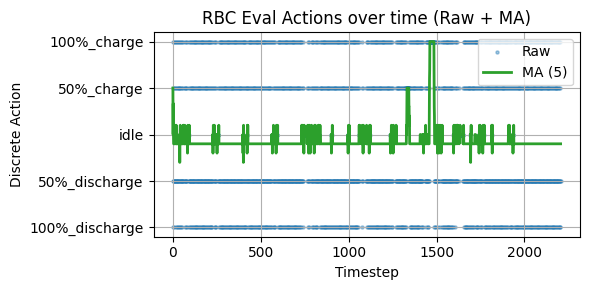

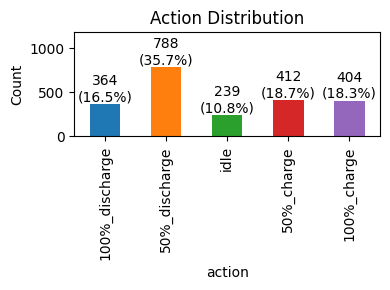

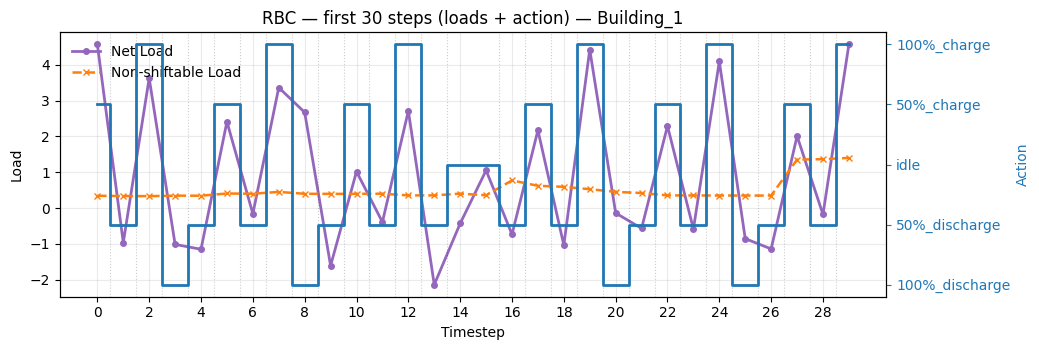

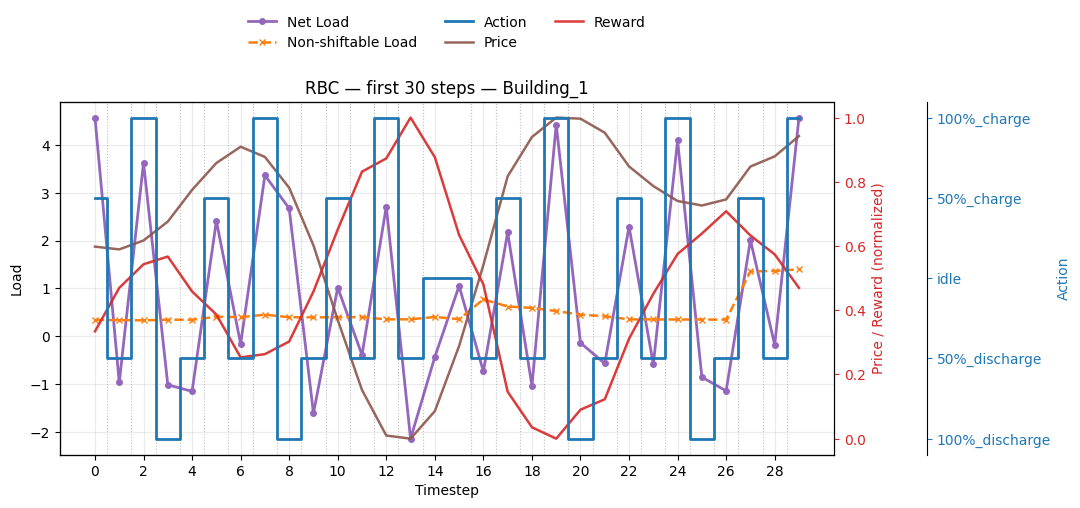

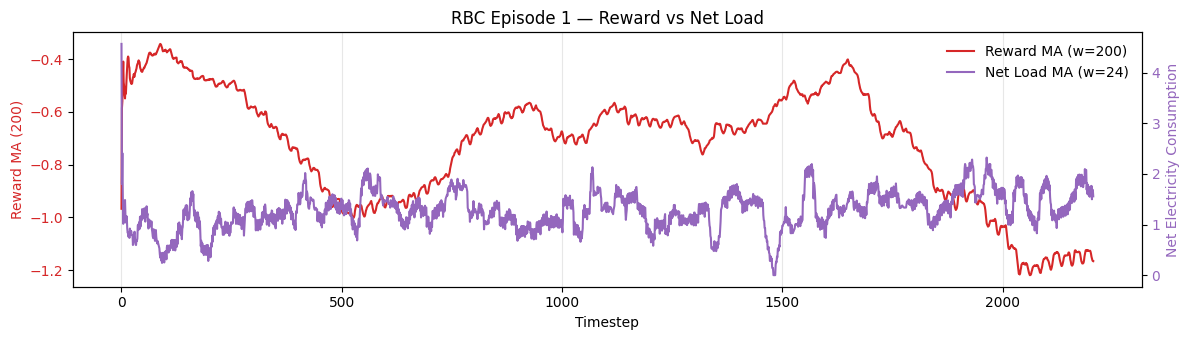

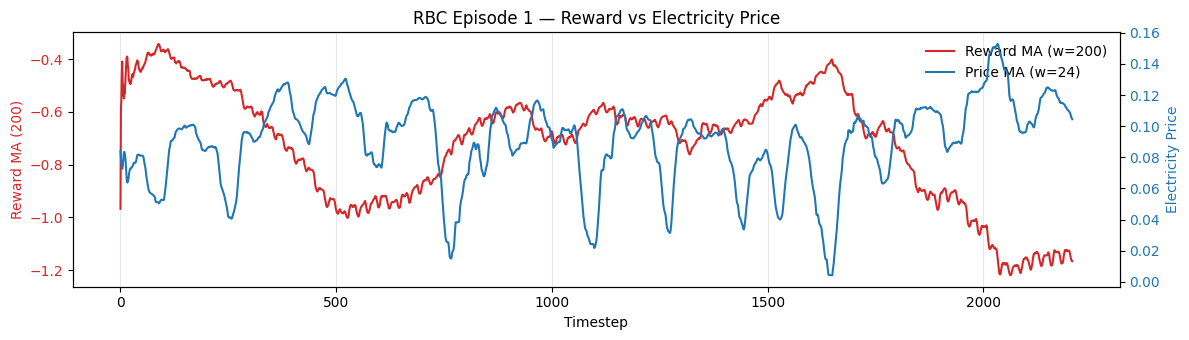

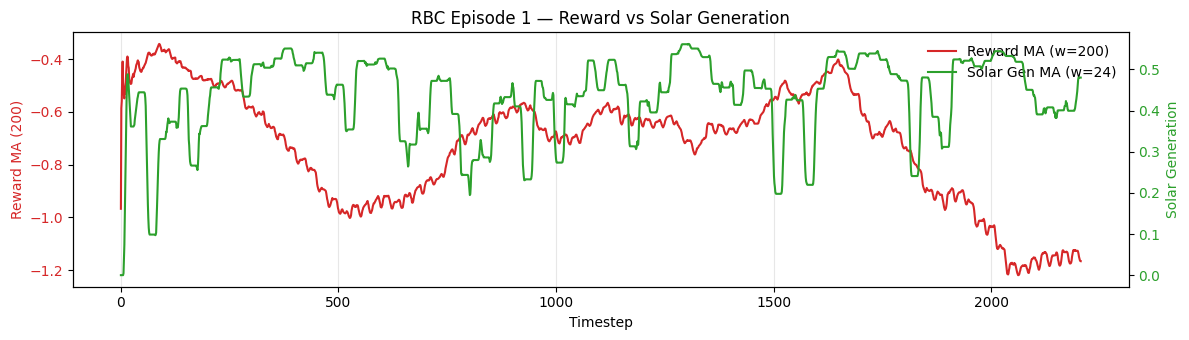

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.plotting_utils import timesteps_to_days
from citylearn.citylearn import CityLearnEnv

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def replay_hist_and_capture(env, hist, building_idx=0, broadcast=False):
    """Replay the recorded actions and capture true arrays per step."""
    base = unwrap_to_citylearn(env)
    base.reset()
    b = base.buildings[building_idx]
    N = base.action_space[0].shape[0]

    NAME_TO_FRAC = {'100%_discharge':-1.0,'50%_discharge':-0.5,'idle':0.0,'50%_charge':0.5,'100%_charge':1.0}

    net_true, nsl_true, price_true, solar_true = [], [], [], []
    for obs_dict, action_name, _ in hist:
        frac = float(np.clip(NAME_TO_FRAC[action_name], -1.0, 1.0))
        if broadcast:
            act = [float(frac)]*N
        else:
            act = [0.0]*N
            act[0] = float(frac)

        # step env
        base.step([act])

        # read current time index and prefer non-zero current idx
        ts_now = b.time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(b.net_electricity_consumption[ts_now])
        net_idx = float(b.net_electricity_consumption[ts_idx])
        net_true.append(net_idx if net_now == 0.0 else net_now)

        nsl_now = float(b.non_shiftable_load[ts_now])
        nsl_idx = float(b.non_shiftable_load[ts_idx])
        nsl_true.append(nsl_idx if nsl_now == 0.0 else nsl_now)

        # optional context
        price_true.append(float(b.pricing.electricity_pricing[ts_now]) if b.pricing is not None else np.nan)
        solar_true.append(float(b.solar_generation[ts_now]))

    return np.array(net_true), np.array(nsl_true), np.array(price_true), np.array(solar_true)

# Attempt to load the log data, handle if file is missing
try:
    df = pd.read_csv('rbc_agent_logs.csv')
except FileNotFoundError:
    print("Log file 'rbc_agent_logs.csv' not found.")

ep_logs = []
for t, (obs, act, rew) in enumerate(hist): # hist: List[(obs_dict, action_str, reward_float)]
    row = {'t': t, 'action': act, 'reward': rew}
    for k in ('soc','price','net_load','solar_generation'):
        if k in obs:
            row[k] = obs[k]
    ep_logs.append(row)
df = pd.DataFrame(ep_logs)

# --- Replace df['net_load'] with replayed true series ---
net_true, nsl_true, price_true, solar_true = replay_hist_and_capture(env, hist, building_idx=0, broadcast=False)
df['net_load'] = net_true
df['non_shiftable_load'] = nsl_true
# (Optionally replace price/solar with true arrays from the building too)
# df['price'] = price_true
# df['solar_generation'] = solar_true

print("Sanity check net_load:", float(np.nanmin(df['net_load'])), "to", float(np.nanmax(df['net_load'])))


# ----- Plot 1: RBC Eval Actions over time (Raw + MA) -----
window = 5
df['action_num'] = df['action'].map(NAME_TO_FRAC)
df['action_ma'] = df['action_num'].rolling(window, min_periods=1).mean()
plt.figure(figsize=(6,3))
plt.scatter(df['t'], df['action_num'], s=5, alpha=0.4, label='Raw')
plt.plot(
    df['t'], 
    df['action_ma'], 
    color='C2', lw=2,
    label=f"MA ({window})"
)
plt.xlabel('Timestep'); 
#df = timesteps_to_days(df)
plt.title(f"RBC Eval Actions over time (Raw + MA)")
plt.yticks([-1.0,-0.5,0.0,0.5,1.0], ACTION_LABELS)
plt.ylabel('Discrete Action'); plt.legend(loc="upper right"); plt.grid(True); plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution -----
plt.figure(figsize=(4,3))
counts = df['action'].value_counts().reindex(ACTION_LABELS).fillna(0)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
def plot_first_30_steps_actions_vs_loads_rbc(agent, env, building_name="Building_1"):
    """Single panel: net & non-shiftable load (left) + discrete action (right), first 30 steps."""
    base = unwrap_to_citylearn(env)
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # Reset and collect first 30 steps
    base.reset()
    t_list, net_list, nsl_list, act_frac_list = [], [], [], []
    for t in range(30):
        # Minimal obs for RBC rule eval (SOC + price if available)
        obs_vec = base.observations[b_idx]
        obs_names_b = base.observation_names[b_idx]
        idx = {n: i for i, n in enumerate(obs_names_b)}
        b0 = base.buildings[b_idx]
        ts = b0.time_step
        soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
        obs_dict = {
            'soc': float(soc),
            'price': float(obs_vec[idx['electricity_pricing']]) if 'electricity_pricing' in idx else np.nan,
        }

        # RBC action -> fraction
        a_name = agent.act(obs_dict)
        a_frac = float(np.clip(NAME_TO_FRAC[a_name], -1.0, 1.0))

        # Control first storage dim only (central agent)
        N = base.action_space[0].shape[0]
        flat = [0.0] * N
        flat[0] = a_frac

        # Step
        _, _, terminated, truncated, _ = base.step([flat])

        # Read arrays (prefer non-zero for net load)
        ts_now = base.buildings[b_idx].time_step
        ts_idx = max(0, ts_now - 1)
        net_now = float(base.buildings[b_idx].net_electricity_consumption[ts_now])
        net_idx = float(base.buildings[b_idx].net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(base.buildings[b_idx].non_shiftable_load[ts_now])
        nsl_idx = float(base.buildings[b_idx].non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        t_list.append(t)
        net_list.append(net_use)
        nsl_list.append(nsl_use)
        act_frac_list.append(a_frac)

        if bool(terminated) or bool(truncated):
            break

    # Arrays
    t = np.arange(len(t_list))
    net = np.asarray(net_list, dtype=float)
    nsl = np.asarray(nsl_list, dtype=float)
    act = np.asarray(act_frac_list, dtype=float)

    # Action change markers
    change_idx = np.where(np.diff(act) != 0)[0]

    # Plot: loads (left) + action (right)
    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', lw=2.0, marker='o', ms=4, label='Net Load')
    ax1.plot(t, nsl, color='C1', lw=1.8, ls='--', marker='x', ms=5, label='Non-shiftable Load')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Load')
    ax1.set_xticks(t[::2])
    ax1.grid(True, which='both', axis='both', alpha=0.25)
    ax1.legend(loc='upper left', frameon=False)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', lw=2.0, label='Action')
    ax2.set_ylabel('Action', color='C0')
    ax2.tick_params(axis='y', colors='C0')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax2.set_yticklabels(ACTION_LABELS)

    for x in change_idx:
        ax1.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.2)

    plt.title(f'RBC — first 30 steps (loads + action) — {building_name}')
    plt.tight_layout()
    plt.show()

plot_first_30_steps_actions_vs_loads_rbc(agent=agent, env=env, building_name="Building_1")



# ----- Plot 4: Action vs Observations -----
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
NAME_TO_FRAC = {'100%_discharge':-1.0,'50%_discharge':-0.5,'idle':0.0,'50%_charge':0.5,'100%_charge':1.0}

def plot_first_30_steps_actions_vs_obs_rbc(agent, env, building_name="Building_1",
                                                          normalize_price_reward: bool = False,
                                                          smooth_window: int = 1):
    base = unwrap_to_citylearn(env)
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # reset
    base.reset()
    t_list, net_list, nsl_list, act_frac_list, price_list, reward_list = [], [], [], [], [], []

    for t in range(30):
        # Build observation dict for the agent (like in evaluate())
        obs_vec = base.observations[b_idx]
        obs_names_b = base.observation_names[b_idx]
        idx = {n: i for i, n in enumerate(obs_names_b)}
        b0 = base.buildings[b_idx]
        ts = b0.time_step
        soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
        obs_dict = {
            'soc': float(soc),
            'price': float(obs_vec[idx['electricity_pricing']]) if 'electricity_pricing' in idx else np.nan,
            'solar_generation': float(obs_vec[idx['solar_generation']]) if 'solar_generation' in idx else np.nan,
        }

        # Agent action (string) -> fraction
        a_name = agent.act(obs_dict)
        a_frac = float(np.clip(NAME_TO_FRAC[a_name], -1.0, 1.0))

        # Central agent action vector (control first storage dim only)
        N = base.action_space[0].shape[0]
        flat = [0.0] * N
        flat[0] = a_frac

        # Step and capture reward
        _, rew, terminated, truncated, _ = base.step([flat])
        step_reward = float(rew[b_idx] if isinstance(rew, (list, tuple, np.ndarray)) else rew)

        # Read arrays (prefer non-zero for net load)
        ts_now = base.buildings[b_idx].time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(base.buildings[b_idx].net_electricity_consumption[ts_now])
        net_idx = float(base.buildings[b_idx].net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(base.buildings[b_idx].non_shiftable_load[ts_now])
        nsl_idx = float(base.buildings[b_idx].non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        price_now = float(base.buildings[b_idx].pricing.electricity_pricing[ts_now]) if base.buildings[b_idx].pricing is not None else np.nan

        t_list.append(t)
        net_list.append(net_use)
        nsl_list.append(nsl_use)
        act_frac_list.append(a_frac)
        price_list.append(price_now)
        reward_list.append(step_reward)

        if bool(terminated) or bool(truncated):
            break

    # Prepare arrays
    t = np.arange(len(t_list))
    net = np.asarray(net_list, dtype=float)
    nsl = np.asarray(nsl_list, dtype=float)
    act = np.asarray(act_frac_list, dtype=float)
    price = np.asarray(price_list, dtype=float)
    reward = np.asarray(reward_list, dtype=float)

    # Optional smoothing for price/reward
    if smooth_window and smooth_window > 1 and len(t) > 1:
        import pandas as _pd
        price = _pd.Series(price).rolling(smooth_window, min_periods=1, center=True).mean().to_numpy()
        reward = _pd.Series(reward).rolling(smooth_window, min_periods=1, center=True).mean().to_numpy()

    # Optional normalization to overlay cleanly on one axis
    def _minmax(x):
        xmin = np.nanmin(x)
        xmax = np.nanmax(x)
        return (x - xmin) / (xmax - xmin + 1e-9) if np.isfinite(xmin) and np.isfinite(xmax) else x

    price_plot = _minmax(price) if normalize_price_reward else price
    reward_plot = _minmax(reward) if normalize_price_reward else reward
    right_label = 'Price / Reward (normalized)' if normalize_price_reward else 'Price / Reward'

    # Find action change points for vertical markers
    change_idx = np.where(np.diff(act) != 0)[0] + 0  # mark at left step

    # Plot
    fig, ax1 = plt.subplots(figsize=(11, 5.2))

    # Left axis: loads
    l1 = ax1.plot(t, net, color='C4', lw=2.0, marker='o', ms=4, label='Net Load')
    l2 = ax1.plot(t, nsl, color='C1', lw=1.8, ls='--', marker='x', ms=5, label='Non-shiftable Load')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Load')
    ax1.grid(True, which='both', axis='both', alpha=0.25)
    ax1.set_xticks(t[::2])

    # Right axis (inner): price and reward
    ax2 = ax1.twinx()
    l4 = ax2.plot(t, price_plot, color='C5', lw=1.8, alpha=0.9, label='Price')
    l5 = ax2.plot(t, reward_plot, color='C3', lw=1.8, alpha=0.9, label='Reward')
    ax2.set_ylabel(right_label, color='C3')
    ax2.tick_params(axis='y', colors='C3')

    # Right axis (outer): action (discrete)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.12))
    ax3.spines['right'].set_visible(True)
    l3 = ax3.step(t, act, where='mid', color='C0', lw=2.0, label='Action')
    ax3.set_ylabel('Action', color='C0')
    ax3.tick_params(axis='y', colors='C0')
    ax3.set_ylim(-1.1, 1.1)
    ax3.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax3.set_yticklabels(ACTION_LABELS)

    # Vertical lines where action changes
    for x in change_idx:
        ax1.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.25)

    # Legend above the curves
    handles = l1 + l2 + [l3[0]] + l4 + l5
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.28), ncol=3, frameon=False)
    plt.subplots_adjust(top=0.80)

    plt.title(f'RBC — first 30 steps — {building_name}')
    plt.tight_layout()
    plt.show()

plot_first_30_steps_actions_vs_obs_rbc(
    agent=agent, env=env, building_name="Building_1", 
    normalize_price_reward=True, 
    smooth_window=5)


# Ensure required columns exist
required_cols = {'t','reward','price','solar_generation','net_load'}
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(f"df is missing columns: {missing}")

# Smoothing windows
window_reward = 200   # steps for reward MA
window_x = 24        # steps for other series MA

# Rolling means
df = df.copy()
df['reward_ma'] = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean()
df['price_ma']  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean()
df['solar_ma']  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean()
df['net_ma']    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean()

t = df['t'].to_numpy()


# 5) Reward vs Net Load
fig, ax1 = plt.subplots(figsize=(12, 3.5))
l1 = ax1.plot(t, df['reward_ma'], color='C3', label=f'Reward MA (w={window_reward})')
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
l2 = ax2.plot(t, df['net_ma'], color='C4', label=f'Net Load MA (w={window_x})')
ax2.set_ylabel('Net Electricity Consumption', color='C4')
ax2.tick_params(axis='y', labelcolor='C4')

lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title("RBC Episode 1 — Reward vs Net Load")
plt.tight_layout(); plt.show()


# 6) Reward vs Electricity Price
fig, ax1 = plt.subplots(figsize=(12, 3.5))
l1 = ax1.plot(t, df['reward_ma'], color='C3', label=f'Reward MA (w={window_reward})')
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
l2 = ax2.plot(t, df['price_ma'], color='C0', label=f'Price MA (w={window_x})')
ax2.set_ylabel('Electricity Price', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title("RBC Episode 1 — Reward vs Electricity Price")
plt.tight_layout(); plt.show()


# 7) Reward vs Solar Generation
fig, ax1 = plt.subplots(figsize=(12, 3.5))
l1 = ax1.plot(t, df['reward_ma'], color='C3', label=f'Reward MA (w={window_reward})')
ax1.set_xlabel('Timestep')
ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
ax1.tick_params(axis='y', labelcolor='C3')
ax1.grid(True, axis='x', alpha=0.3)

ax2 = ax1.twinx()
l2 = ax2.plot(t, df['solar_ma'], color='C2', label=f'Solar Gen MA (w={window_x})')
ax2.set_ylabel('Solar Generation', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title("RBC Episode 1 — Reward vs Solar Generation")
plt.tight_layout(); plt.show()

/scratch/slurm_tmpdir/job_1540709/ipykernel_300754/330699709.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


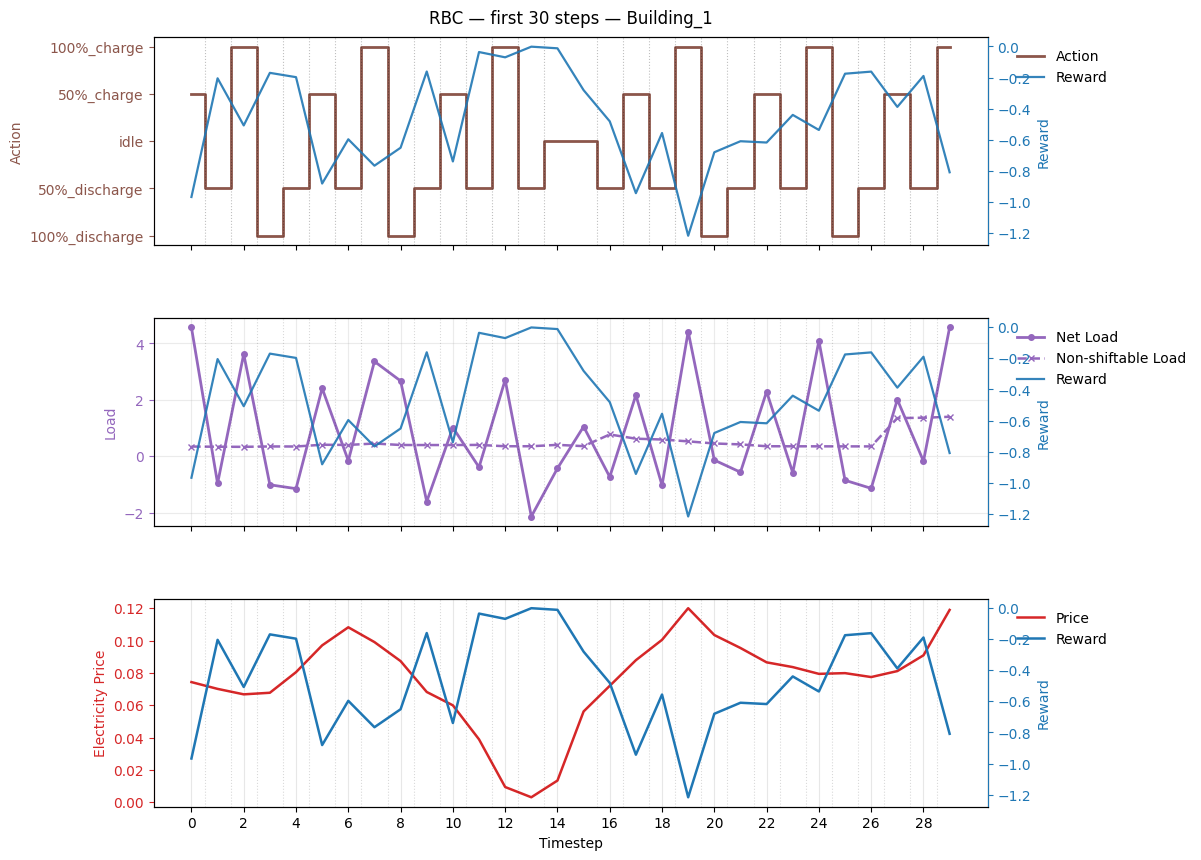

In [7]:
def plot_first_30_steps_split_rbc(agent, env, building_name="Building_1"):
    """Three aligned panels: (1) actions + reward, (2) net & non-shiftable load + reward, (3) reward vs price (raw)."""
    base = unwrap_to_citylearn(env)
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # Reset and collect first 30 steps
    base.reset()
    t_list, net_list, nsl_list, act_frac_list, price_list, reward_list = [], [], [], [], [], []
    for t in range(30):
        # Minimal obs for rule eval
        obs_vec = base.observations[b_idx]
        obs_names_b = base.observation_names[b_idx]
        idx = {n: i for i, n in enumerate(obs_names_b)}
        b0 = base.buildings[b_idx]
        ts = b0.time_step
        soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
        obs_dict = {
            'soc': float(soc),
            'price': float(obs_vec[idx['electricity_pricing']]) if 'electricity_pricing' in idx else np.nan,
            'solar_generation': float(obs_vec[idx['solar_generation']]) if 'solar_generation' in idx else np.nan,
        }

        # Agent action -> fraction
        a_name = agent.act(obs_dict)
        a_frac = float(np.clip(NAME_TO_FRAC[a_name], -1.0, 1.0))

        # Central action vector (control first storage dim only)
        N = base.action_space[0].shape[0]
        flat = [0.0] * N
        flat[0] = a_frac

        # Step and capture reward
        _, rew, terminated, truncated, _ = base.step([flat])
        step_reward = float(rew[b_idx] if isinstance(rew, (list, tuple, np.ndarray)) else rew)

        # Read arrays (prefer non-zero for net load)
        ts_now = base.buildings[b_idx].time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(base.buildings[b_idx].net_electricity_consumption[ts_now])
        net_idx = float(base.buildings[b_idx].net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(base.buildings[b_idx].non_shiftable_load[ts_now])
        nsl_idx = float(base.buildings[b_idx].non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        price_now = float(base.buildings[b_idx].pricing.electricity_pricing[ts_now]) if base.buildings[b_idx].pricing is not None else np.nan

        t_list.append(t)
        net_list.append(net_use)
        nsl_list.append(nsl_use)
        act_frac_list.append(a_frac)
        price_list.append(price_now)
        reward_list.append(step_reward)

        if bool(terminated) or bool(truncated):
            break

    # Arrays
    t = np.arange(len(t_list))
    net = np.asarray(net_list, dtype=float)
    nsl = np.asarray(nsl_list, dtype=float)
    act = np.asarray(act_frac_list, dtype=float)
    price = np.asarray(price_list, dtype=float)     # raw
    reward = np.asarray(reward_list, dtype=float)   # raw

    # Change markers where action changes
    change_idx = np.where(np.diff(act) != 0)[0]

    # Figure with 3 aligned panels (taller + more spacing)
    fig, axs = plt.subplots(3, 1, figsize=(12, 9.5), sharex=True, gridspec_kw={'hspace': 0.35})
    plt.subplots_adjust(right=0.82, top=0.92)  # leave room on right for legends

    # Panel 1: Actions (left, C5) + Reward (right, C0)
    ax1 = axs[0]
    lA = ax1.step(t, act, where='mid', color='C5', lw=2.0, label='Action')
    ax1.set_ylabel('Action', color='C5')
    ax1.tick_params(axis='y', colors='C5')
    ax1.spines['left'].set_color('C5')
    ax1.set_ylim(-1.1, 1.1)
    ax1.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax1.set_yticklabels(ACTION_LABELS)
    for x in change_idx:
        ax1.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.25)
    ax1.set_title(f'RBC — first 30 steps — {building_name}', pad=10)

    ax1r = ax1.twinx()
    lR1 = ax1r.plot(t, reward, color='C0', lw=1.6, alpha=0.9, label='Reward')
    ax1r.set_ylabel('Reward', color='C0')
    ax1r.tick_params(axis='y', colors='C0')
    ax1r.spines['right'].set_color('C0')
    ax1.legend([lA[0], lR1[0]], ['Action', 'Reward'], loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    # Panel 2: Net (C4) & Non-shiftable (C4) + Reward (right, C0)
    ax2 = axs[1]
    lN = ax2.plot(t, net, color='C4', lw=2.0, marker='o', ms=4, label='Net Load')
    lB = ax2.plot(t, nsl, color='C4', lw=1.8, ls='--', marker='x', ms=5, label='Non-shiftable Load')
    ax2.set_ylabel('Load', color='C4')      # emphasize Net Load color
    ax2.tick_params(axis='y', colors='C4')
    ax2.spines['left'].set_color('C4')
    ax2.grid(True, which='both', axis='both', alpha=0.25)
    for x in change_idx:
        ax2.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.15)

    ax2r = ax2.twinx()
    lR2 = ax2r.plot(t, reward, color='C0', lw=1.6, alpha=0.9, label='Reward')
    ax2r.set_ylabel('Reward', color='C0')
    ax2r.tick_params(axis='y', colors='C0')
    ax2r.spines['right'].set_color('C0')

    ax2.legend([lN[0], lB[0], lR2[0]], ['Net Load', 'Non-shiftable Load', 'Reward'],
               loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    # Panel 3: Price (left, C3) vs Reward (right, C0) — raw units
    ax3l = axs[2]
    l1 = ax3l.plot(t, price, color='C3', lw=1.8, label='Price')
    ax3l.set_ylabel('Electricity Price', color='C3')
    ax3l.tick_params(axis='y', colors='C3')
    ax3l.spines['left'].set_color('C3')
    ax3l.grid(True, axis='x', alpha=0.3)

    ax3r = ax3l.twinx()
    l2 = ax3r.plot(t, reward, color='C0', lw=1.8, label='Reward')
    ax3r.set_ylabel('Reward', color='C0')
    ax3r.tick_params(axis='y', colors='C0')
    ax3r.spines['right'].set_color('C0')

    # Combined legend (outside)
    lines = l1 + l2
    ax3l.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    for x in change_idx:
        ax3l.axvline(x=x + 0.5, color='k', ls=':', lw=0.8, alpha=0.15)

    axs[-1].set_xlabel('Timestep')
    axs[0].set_xticks(t[::2])

    plt.tight_layout()
    plt.show()

# Use the split version (raw price/reward)
plot_first_30_steps_split_rbc(agent=agent, env=env, building_name="Building_1")